# Part 3: Ranking

## Imports

In [1]:
import pandas as pd
from collections import defaultdict
import numpy as np
import re
import nltk
import contractions
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.manifold import TSNE
import matplotlib
import matplotlib.pyplot 

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.corpus import stopwords

import matplotlib.pyplot as plt
import seaborn as sns

[nltk_data] Downloading package stopwords to C:\Users\Josep
[nltk_data]     Alet\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\Josep
[nltk_data]     Alet\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to C:\Users\Josep
[nltk_data]     Alet\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [2]:
df = pd.read_csv('processed_tweets.csv').drop(columns=['Unnamed: 0'])

### From these results of part 2 we had concluded that some queries could be:

In [3]:
Q1="florida hurrican"

Q2="help people in florida"

Q3="hurrican ian major damages"

Q4="storm impact in Florida"

Q5="floodings in the south"

# a) Scoring using TF-IDF + Cosine Similarity 

In [4]:
def extract_tweet_vocabulary(tweet, docId):
    return {term: docId for term in tweet.split(' ')}

In [5]:
def merge_dicts(dicts):
    vocab = defaultdict(list)
    for dic in dicts:
        for term in dic:
            vocab[term].append(dic[term])
    return dict(vocab)

In [6]:
tweets_dicts = map(extract_tweet_vocabulary, df['Tweet'], df['DocID'])
vocabulary = merge_dicts(tweets_dicts)
print(f"Vocabulary has {len(vocabulary)} words")

Vocabulary has 10671 words


In [7]:
def build_TF_IDF(df, vocabulary):
    terms = vocabulary.keys()
    docs = df.DocID
    N = len(docs)
    tf_idf = dict()
    
    for doc in docs:
        tf_idf[doc] = {}
    
    for term in terms:
        for doc in vocabulary[term]:
            tf = df[df.DocID == doc].Tweet.iloc[0].split().count(term)
            if tf>0:
                df_i = len(vocabulary[term])
                tf_idf[doc][term] = (1+np.log(tf))*np.log(N/df_i)
            else:
                tf_idf[doc][term] = 0
    return tf_idf

In [8]:
def find_doc2norm(tf_idf):
    docs = tf_idf.keys()
    doc2norm = {}
    for doc in docs:
        doc2norm[doc] = np.linalg.norm(np.array(list(tf_idf[doc].values())))
    return doc2norm

In [9]:
def find_term2sum(tf_idf):
    terms = vocabulary.keys()
    docs = tf_idf.keys()
    term2sum = {term:0 for term in terms}
    for doc in docs:
        for term, value in tf_idf[doc].items():
            term2sum[term] += value
    term2sum = {t: v for t, v in sorted(term2sum.items(), key=lambda item: item[1], reverse=True)}
    return term2sum

In [10]:
tf_idf = build_TF_IDF(df, vocabulary)

In [11]:
doc2norm = find_doc2norm(tf_idf)
term2sum = find_term2sum(tf_idf)

In [12]:
def build_terms(line):
    """
    Preprocess the tweet content removing stop words, contractionas and urls
    lemmatizing and stemming words to keep a single word for each family of words
    transforming in lowercase, removing special characters [#, @, .] 
    (since it is included in another column on the dataframe)
    
    return tokenized tweet (list of words after applying the previous steps).
    
    Argument:
    line -- string (tweet) to be preprocessed
    
    Returns:
    line - a list of tokens corresponding to the input text after the preprocessing
    """
    ## START CODE
    line = line.lower() ##Transform in lowercase
    line = re.sub(r"[^A-Za-z 0-9 ']+", '', line) # remove emojis and any other special character
    stop_words = set(stopwords.words("english")) # removing stopwords
    line = ' '.join([contractions.fix(x) for x in line.split(' ')]) # expaning verb abreviations: i'll -> i will 
    line = re.sub("'", '', line) 
    line = line.split(' ')
    line = [x for x in line if x and x not in stop_words]
    line = filter(lambda x:x[0:5]!='https', line) # removing links
    line = [x for x in line]
    ps = PorterStemmer() 
    lemmatizer = WordNetLemmatizer() 
    line = [lemmatizer.lemmatize(x) for x in line] # keeping the singular form of each noun: feet --> foot
    line = [ps.stem(x) for x in line] # keeping the root of each family of words: dancer --> danc
    
    ## END CODE
    return ' '.join(line)

In [13]:
def rank(query, tf_idf, vocabulary):
    N = len(tf_idf.keys())
    terms_query = build_terms(query).split()
    terms_q = list(set(terms_query))
    tf_idf_q = dict()
    
    for term_q in terms_q:
        f_iq = terms_query.count(term_q)
        if term_q not in vocabulary:
            continue
        df_i = len([doc for doc in vocabulary[term_q] if doc in tf_idf.keys()])
        if df_i>0:
            tf_idf_q[term_q] = (1+np.log(f_iq))*np.log(N/df_i)
        else:
            tf_idf_q[term_q]=0
    q_norm = np.linalg.norm(np.array(list(tf_idf_q.values())))
    doc2score = dict()
    
    doc2norm = find_doc2norm(tf_idf)
    
    for doc, dix in tf_idf.items():
        dot_product = 0
        for term, value in dix.items():
            if term in tf_idf_q.keys():
                dot_product += value * tf_idf_q[term]
        doc2score[doc] = dot_product / (doc2norm[doc] * q_norm)
    doc2score = {t: v for t, v in sorted(doc2score.items(), key=lambda item: item[1], reverse=True)}
    return doc2score

In [14]:
doc2score_Q1 = rank(Q1, tf_idf, vocabulary)
top = 10
print(f"Top {top} docs for query 1 ('{Q1}'):")
for i in range(top):
    doc, score = list(doc2score_Q1.items())[i]
    print(f"\t {i+1}) {doc} with a score of {score} and with the following information:\n{df[df.DocID == doc].iloc[0]}")

Top 10 docs for query 1 ('florida hurrican'):
	 1) doc_640 with a score of 0.5015566349200697 and with the following information:
DocID                                                 doc_640
Tweet                               hurrican ian hurricaneian
Username                                         kadenfields8
Date                           Fri Sep 30 18:07:50 +0000 2022
Hashtags                                     ['HurricaneIan']
Likes                                                       2
Retweets                                                    0
Url         https://twitter.com/kadenfields8/status/157591...
Name: 639, dtype: object
	 2) doc_733 with a score of 0.32852179583698915 and with the following information:
DocID                                                 doc_733
Tweet       experi hurrican check hurricaneian bless hurri...
Username                                         daniel_bautz
Date                           Fri Sep 30 18:04:05 +0000 2022
Hashtags    ['hu

In [15]:
doc2score_Q2 = rank(Q2, tf_idf, vocabulary)
top = 10
print(f"Top {top} docs for query 2 ('{Q2}'):")
for i in range(top):
    doc, score = list(doc2score_Q2.items())[i]
    print(f"\t {i+1}) {doc} with a score of {score} and with the following information:\n{df[df.DocID == doc].iloc[0]}")

Top 10 docs for query 2 ('help people in florida'):
	 1) doc_3682 with a score of 0.37023387134694796 and with the following information:
DocID                                                doc_3682
Tweet       good morn love yesterday employ sent email don...
Username                                         KandiSamples
Date                           Fri Sep 30 14:49:25 +0000 2022
Hashtags                                     ['HurricaneIan']
Likes                                                       3
Retweets                                                    0
Url         https://twitter.com/KandiSamples/status/157586...
Name: 3681, dtype: object
	 2) doc_812 with a score of 0.34574116813941735 and with the following information:
DocID                                                 doc_812
Tweet       look organ provid help hurricaneian victim cen...
Username                                         ChristieZizo
Date                           Fri Sep 30 18:00:53 +0000 2022
Hashtag

In [16]:
doc2score_Q3 = rank(Q3, tf_idf, vocabulary)
top = 10
print(f"Top {top} docs for query 3 ('{Q3}'):")
for i in range(top):
    doc, score = list(doc2score_Q3.items())[i]
    print(f"\t {i+1}) {doc} with a score of {score} and with the following information:\n{df[df.DocID == doc].iloc[0]}")

Top 10 docs for query 3 ('hurrican ian major damages'):
	 1) doc_1083 with a score of 0.3880462691741326 and with the following information:
DocID                                                doc_1083
Tweet                flood major concern gardenc hurricaneian
Username                                      Annette_Peagler
Date                           Fri Sep 30 17:46:24 +0000 2022
Hashtags                       ['GardenCity', 'HurricaneIan']
Likes                                                       3
Retweets                                                    2
Url         https://twitter.com/Annette_Peagler/status/157...
Name: 1082, dtype: object
	 2) doc_640 with a score of 0.3843417729584876 and with the following information:
DocID                                                 doc_640
Tweet                               hurrican ian hurricaneian
Username                                         kadenfields8
Date                           Fri Sep 30 18:07:50 +0000 2022
Hasht

In [17]:
doc2score_Q4 = rank(Q4, tf_idf, vocabulary)
top = 10
print(f"Top {top} docs for query 4 ('{Q4}'):")
for i in range(top):
    doc, score = list(doc2score_Q4.items())[i]
    print(f"\t {i+1}) {doc} with a score of {score} and with the following information:\n{df[df.DocID == doc].iloc[0]}")

Top 10 docs for query 4 ('storm impact in Florida'):
	 1) doc_2045 with a score of 0.4365974215379949 and with the following information:
DocID                                                doc_2045
Tweet       hurrican ian left devast impact mani part flor...
Username                                        RCMHealthcare
Date                           Fri Sep 30 16:22:18 +0000 2022
Hashtags          ['HurricaneIan', 'HealthCareProfessionals']
Likes                                                       0
Retweets                                                    0
Url         https://twitter.com/RCMHealthcare/status/15758...
Name: 2044, dtype: object
	 2) doc_1065 with a score of 0.353869704308813 and with the following information:
DocID                                                doc_1065
Tweet       thought neighbor florida impact devast hurrica...
Username                                         launitedways
Date                           Fri Sep 30 17:48:03 +0000 2022
Hashtags

In [18]:
doc2score_Q5 = rank(Q5, tf_idf, vocabulary)
top = 10
print(f"Top {top} docs for query 5 ('{Q5}'):")
for i in range(top):
    doc, score = list(doc2score_Q5.items())[i]
    print(f"\t {i+1}) {doc} with a score of {score} and with the following information:\n{df[df.DocID == doc].iloc[0]}")

Top 10 docs for query 5 ('floodings in the south'):
	 1) doc_254 with a score of 0.5127787107942561 and with the following information:
DocID                                                 doc_254
Tweet                             south carolina hurricaneian
Username                                             webgyrl2
Date                           Fri Sep 30 18:26:13 +0000 2022
Hashtags                                     ['HurricaneIan']
Likes                                                       0
Retweets                                                    0
Url         https://twitter.com/webgyrl2/status/1575914929...
Name: 253, dtype: object
	 2) doc_174 with a score of 0.4146748622439571 and with the following information:
DocID                                                 doc_174
Tweet                          south carolina hurricaneian go
Username                                      TheAstuteGaloot
Date                           Fri Sep 30 18:30:20 +0000 2022
Hashtags   

# b) Own score + cosine similarity


In [19]:
doc2extra_score = dict()

for index, row in df.iterrows():
    extra_score = 0.25 * np.log(1 + np.log(1 + (np.log(1 + row["Likes"]) + 2 * np.log(1 + row["Retweets"])) / np.log(1 + len(row["Hashtags"].split(",")))))
    doc2extra_score[row["DocID"]] = extra_score

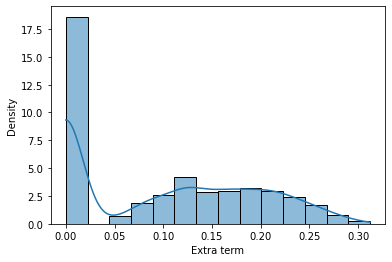

In [20]:
sns.histplot(np.log(1 + np.array(list(doc2extra_score.values()))), stat="density", kde=True)
plt.xlabel("Extra term")
plt.show()

In [21]:
def new_rank(query, tf_idf, vocabulary, doc2extra_score):
    N = len(tf_idf.keys())
    terms_query = build_terms(query).split()
    terms_q = list(set(terms_query))
    tf_idf_q = dict()
    
    for term_q in terms_q:
        f_iq = terms_query.count(term_q)
        if term_q not in vocabulary:
            continue
        df_i = len([doc for doc in vocabulary[term_q] if doc in tf_idf.keys()])
        if df_i>0:
            tf_idf_q[term_q] = (1+np.log(f_iq))*np.log(N/df_i)
        else:
            tf_idf_q[term_q]=0
    q_norm = np.linalg.norm(np.array(list(tf_idf_q.values())))
    doc2score = dict()
    
    doc2norm = find_doc2norm(tf_idf)
    
    for doc, dix in tf_idf.items():
        dot_product = 0
        for term, value in dix.items():
            if term in tf_idf_q.keys():
                dot_product += value * tf_idf_q[term]
        doc2score[doc] = dot_product / (doc2norm[doc] * q_norm) + doc2extra_score[doc]
    doc2score = {t: v for t, v in sorted(doc2score.items(), key=lambda item: item[1], reverse=True)}
    return doc2score

In [22]:
doc2score_Q1 = new_rank(Q1, tf_idf, vocabulary, doc2extra_score)
top = 10
print(f"Top {top} docs for query 1 ('{Q1}'):")
for i in range(top):
    doc, score = list(doc2score_Q1.items())[i]
    print(f"\t {i+1}) {doc} with a score of {score} and with the following information:\n{df[df.DocID == doc].iloc[0]}")

Top 10 docs for query 1 ('florida hurrican'):
	 1) doc_640 with a score of 0.6684769242110052 and with the following information:
DocID                                                 doc_640
Tweet                               hurrican ian hurricaneian
Username                                         kadenfields8
Date                           Fri Sep 30 18:07:50 +0000 2022
Hashtags                                     ['HurricaneIan']
Likes                                                       2
Retweets                                                    0
Url         https://twitter.com/kadenfields8/status/157591...
Name: 639, dtype: object
	 2) doc_3072 with a score of 0.47521149699612636 and with the following information:
DocID                                                doc_3072
Tweet       help reach america serv florida resid impact h...
Username                                              UPCIORG
Date                           Fri Sep 30 15:22:01 +0000 2022
Hashtags       

In [23]:
doc2score_Q2 = new_rank(Q2, tf_idf, vocabulary, doc2extra_score)
top = 10
print(f"Top {top} docs for query 2 ('{Q2}'):")
for i in range(top):
    doc, score = list(doc2score_Q2.items())[i]
    print(f"\t {i+1}) {doc} with a score of {score} and with the following information:\n{df[df.DocID == doc].iloc[0]}")

Top 10 docs for query 2 ('help people in florida'):
	 1) doc_3682 with a score of 0.5555529491907019 and with the following information:
DocID                                                doc_3682
Tweet       good morn love yesterday employ sent email don...
Username                                         KandiSamples
Date                           Fri Sep 30 14:49:25 +0000 2022
Hashtags                                     ['HurricaneIan']
Likes                                                       3
Retweets                                                    0
Url         https://twitter.com/KandiSamples/status/157586...
Name: 3681, dtype: object
	 2) doc_1202 with a score of 0.5430967128375834 and with the following information:
DocID                                                doc_1202
Tweet       thank everyon across nation state want help pe...
Username                                           NikkiFried
Date                           Fri Sep 30 17:38:18 +0000 2022
Hashtags

In [24]:
doc2score_Q3 = new_rank(Q3, tf_idf, vocabulary, doc2extra_score)
top = 10
print(f"Top {top} docs for query 3 ('{Q3}'):")
for i in range(top):
    doc, score = list(doc2score_Q3.items())[i]
    print(f"\t {i+1}) {doc} with a score of {score} and with the following information:\n{df[df.DocID == doc].iloc[0]}")

Top 10 docs for query 3 ('hurrican ian major damages'):
	 1) doc_1083 with a score of 0.6120382295349347 and with the following information:
DocID                                                doc_1083
Tweet                flood major concern gardenc hurricaneian
Username                                      Annette_Peagler
Date                           Fri Sep 30 17:46:24 +0000 2022
Hashtags                       ['GardenCity', 'HurricaneIan']
Likes                                                       3
Retweets                                                    2
Url         https://twitter.com/Annette_Peagler/status/157...
Name: 1082, dtype: object
	 2) doc_640 with a score of 0.5512620622494231 and with the following information:
DocID                                                 doc_640
Tweet                               hurrican ian hurricaneian
Username                                         kadenfields8
Date                           Fri Sep 30 18:07:50 +0000 2022
Hasht

In [25]:
doc2score_Q4 = new_rank(Q4, tf_idf, vocabulary, doc2extra_score)
top = 10
print(f"Top {top} docs for query 4 ('{Q4}'):")
for i in range(top):
    doc, score = list(doc2score_Q4.items())[i]
    print(f"\t {i+1}) {doc} with a score of {score} and with the following information:\n{df[df.DocID == doc].iloc[0]}")

Top 10 docs for query 4 ('storm impact in Florida'):
	 1) doc_446 with a score of 0.5821290643970822 and with the following information:
DocID                                                 doc_446
Tweet       pawley island polic keep tab hurricaneian stor...
Username                                            wyffnews4
Date                           Fri Sep 30 18:17:04 +0000 2022
Hashtags                                     ['HurricaneIan']
Likes                                                      18
Retweets                                                   10
Url         https://twitter.com/wyffnews4/status/157591263...
Name: 445, dtype: object
	 2) doc_1519 with a score of 0.5618482293971625 and with the following information:
DocID                                                doc_1519
Tweet         impact hurrican ian thought prayer hurricaneian
Username                                      GenerationalGrp
Date                           Fri Sep 30 17:11:36 +0000 2022
Hashtags 

In [26]:
doc2score_Q5 = new_rank(Q5, tf_idf, vocabulary, doc2extra_score)
top = 10
print(f"Top {top} docs for query 5 ('{Q5}'):")
for i in range(top):
    doc, score = list(doc2score_Q5.items())[i]
    print(f"\t {i+1}) {doc} with a score of {score} and with the following information:\n{df[df.DocID == doc].iloc[0]}")

Top 10 docs for query 5 ('floodings in the south'):
	 1) doc_2505 with a score of 0.5878006122888806 and with the following information:
DocID                                                doc_2505
Tweet                hurricaneian make landfal south carolina
Username                                           JoshFitzWx
Date                           Fri Sep 30 15:50:13 +0000 2022
Hashtags                                     ['HurricaneIan']
Likes                                                       2
Retweets                                                    1
Url         https://twitter.com/JoshFitzWx/status/15758756...
Name: 2504, dtype: object
	 2) doc_174 with a score of 0.5463221207787182 and with the following information:
DocID                                                 doc_174
Tweet                          south carolina hurricaneian go
Username                                      TheAstuteGaloot
Date                           Fri Sep 30 18:30:20 +0000 2022
Hashtags 

# c) BM25

In [27]:
x = {1: 2, 3: 4, 4: 3, 2: 1, 0: 0}
a = {k: v for k, v in sorted(x.items(), key=lambda item: item[1], reverse=True)}
print(a)

{3: 4, 4: 3, 1: 2, 2: 1, 0: 0}


In [28]:
def BM25(query, vocabulary, k1, b, L_ave, doc_contents):
    '''
    vocabulary = inverted index, dictionary with keys = terms an values = list of doc_ids
    k1 = value to regulate xx
    b = value to regulate yy
    L_ave = average length of docs in words
    doc_contents = dictionary where keys = doc_ids and values = list of terms (after text processing)
    '''
    
    RSV = dict()
    N = len(doc_contents)
    terms_q = list(set(build_terms(query).split()))
    idf = dict()
    
    # calculate idf for each term in the query 
    for t in terms_q:
        f_tq = terms_q.count(t)
        if t not in vocabulary:
            continue
        df_t = len(vocabulary[t])
        idf[t] = np.log(N/df_t)
        
    # calculate RSVd for each document  
    for doc in doc_contents.keys():
        RSV[doc] = 0
        Ld = len(doc_contents[doc])
        for t in idf.keys():
            tf_t_d = doc_contents[doc].count(t)

            second_term = ((k1+1)*tf_t_d) / (k1*((1-b)+b*(Ld/L_ave))+tf_t_d)
            RSV[doc] += idf[t]*second_term
            
    return {k: v for k, v in sorted(RSV.items(), key=lambda item: item[1], reverse=True)}
            

In [29]:
k1 = 1
b = 1
L_ave = np.mean([len(x.split()) for x in df.Tweet])
print(L_ave)
dictionary_doc = df.copy().drop(columns=['Username', 'Date', 'Hashtags', 'Likes', 'Retweets', 'Url'])
dictionary_doc = dictionary_doc.set_index('DocID').T.to_dict('list')
dictionary_doc = {k: x[0].split() for k, x in dictionary_doc.items()}

15.4405


In [30]:
doc2score_Q1 = BM25(Q1, vocabulary, k1, b, L_ave, dictionary_doc)
top = 10
print(f"Top {top} docs for query 1 ('{Q1}'):")
for i in range(top):
    doc, score = list(doc2score_Q1.items())[i]
    print(f"\t {i+1}) {doc} with a score of {score} and with the following information:\n{df[df.DocID == doc].iloc[0]}")

Top 10 docs for query 1 ('florida hurrican'):
	 1) doc_733 with a score of 4.823013920176516 and with the following information:
DocID                                                 doc_733
Tweet       experi hurrican check hurricaneian bless hurri...
Username                                         daniel_bautz
Date                           Fri Sep 30 18:04:05 +0000 2022
Hashtags    ['hurricaneian', 'blessed', 'hurricane', 'flor...
Likes                                                       0
Retweets                                                    0
Url         https://twitter.com/daniel_bautz/status/157590...
Name: 732, dtype: object
	 2) doc_2877 with a score of 4.611497449676531 and with the following information:
DocID                                                doc_2877
Tweet       hurrican ian cuba florida south carolinahurric...
Username                                          DanielsBias
Date                           Fri Sep 30 15:30:32 +0000 2022
Hashtags          

In [31]:
doc2score_Q2 = BM25(Q2, vocabulary, k1, b, L_ave, dictionary_doc)
top = 10
print(f"Top {top} docs for query 2 ('{Q2}'):")
for i in range(top):
    doc, score = list(doc2score_Q2.items())[i]
    print(f"\t {i+1}) {doc} with a score of {score} and with the following information:\n{df[df.DocID == doc].iloc[0]}")

Top 10 docs for query 2 ('help people in florida'):
	 1) doc_191 with a score of 8.557332010720172 and with the following information:
DocID                                                 doc_191
Tweet       sengarypet senstabenowjust wonder quiet help p...
Username                                          woodsmanguy
Date                           Fri Sep 30 18:29:54 +0000 2022
Hashtags                                     ['HurricaneIan']
Likes                                                       0
Retweets                                                    0
Url         https://twitter.com/woodsmanguy/status/1575915...
Name: 190, dtype: object
	 2) doc_898 with a score of 8.220965508068096 and with the following information:
DocID                                                 doc_898
Tweet       donaldjtrumpjr even tri open chariti help peop...
Username                                       AlbertTinsdale
Date                           Fri Sep 30 17:57:51 +0000 2022
Hashtags     

In [32]:
doc2score_Q3 = BM25(Q3, vocabulary, k1, b, L_ave, dictionary_doc)
top = 10
print(f"Top {top} docs for query 3 ('{Q3}'):")
for i in range(top):
    doc, score = list(doc2score_Q3.items())[i]
    print(f"\t {i+1}) {doc} with a score of {score} and with the following information:\n{df[df.DocID == doc].iloc[0]}")

Top 10 docs for query 3 ('hurrican ian major damages'):
	 1) doc_1373 with a score of 7.7591863792139675 and with the following information:
DocID                                                doc_1373
Tweet       hurrican ian leaf behind histor damag depart f...
Username                                               Mar_Ex
Date                           Fri Sep 30 17:28:37 +0000 2022
Hashtags            ['maritime', 'hurricane', 'hurricaneian']
Likes                                                       0
Retweets                                                    0
Url         https://twitter.com/Mar_Ex/status/157590043796...
Name: 1372, dtype: object
	 2) doc_1083 with a score of 7.3919997354703515 and with the following information:
DocID                                                doc_1083
Tweet                flood major concern gardenc hurricaneian
Username                                      Annette_Peagler
Date                           Fri Sep 30 17:46:24 +0000 2022
Hash

In [33]:
doc2score_Q4 = BM25(Q4, vocabulary, k1, b, L_ave, dictionary_doc)
top = 10
print(f"Top {top} docs for query 4 ('{Q4}'):")
for i in range(top):
    doc, score = list(doc2score_Q4.items())[i]
    print(f"\t {i+1}) {doc} with a score of {score} and with the following information:\n{df[df.DocID == doc].iloc[0]}")

Top 10 docs for query 4 ('storm impact in Florida'):
	 1) doc_2045 with a score of 8.266658006264807 and with the following information:
DocID                                                doc_2045
Tweet       hurrican ian left devast impact mani part flor...
Username                                        RCMHealthcare
Date                           Fri Sep 30 16:22:18 +0000 2022
Hashtags          ['HurricaneIan', 'HealthCareProfessionals']
Likes                                                       0
Retweets                                                    0
Url         https://twitter.com/RCMHealthcare/status/15758...
Name: 2044, dtype: object
	 2) doc_611 with a score of 7.560792552537883 and with the following information:
DocID                                                 doc_611
Tweet       thought resid florida impact hurricaneian lear...
Username                                      StateFarmLatino
Date                           Fri Sep 30 18:09:01 +0000 2022
Hashtags  

In [34]:
doc2score_Q5 = BM25(Q5, vocabulary, k1, b, L_ave, dictionary_doc)
top = 10
print(f"Top {top} docs for query 5 ('{Q5}'):")
for i in range(top):
    doc, score = list(doc2score_Q5.items())[i]
    print(f"\t {i+1}) {doc} with a score of {score} and with the following information:\n{df[df.DocID == doc].iloc[0]}")

Top 10 docs for query 5 ('floodings in the south'):
	 1) doc_1289 with a score of 7.080615418817565 and with the following information:
DocID                                                doc_1289
Tweet       flood garden citi south carolina gardenc south...
Username                                           skyflyer81
Date                           Fri Sep 30 17:33:51 +0000 2022
Hashtags      ['GardenCity', 'SouthCarolina', 'HurricaneIan']
Likes                                                       1
Retweets                                                    0
Url         https://twitter.com/skyflyer81/status/15759017...
Name: 1288, dtype: object
	 2) doc_2484 with a score of 6.790907130573971 and with the following information:
DocID                                                doc_2484
Tweet       flood trap mani florida ian head south carolin...
Username                                           bettycjung
Date                           Fri Sep 30 15:51:21 +0000 2022
Hashtags  

# 2. Word2vec + cosine similarity

In [35]:
import gensim
from gensim.models import Word2Vec
from numpy import dot
from numpy.linalg import norm

In [36]:
# storing doc words in a list of lists 
docs_as_words = []
for k in dictionary_doc.keys():
    docs_as_words.append(dictionary_doc[k])

In [37]:
# training model for word2vec
model1 = gensim.models.Word2Vec(docs_as_words, min_count = 1,
                              vector_size = 100, window = 5)

In [38]:
# function to convert any text to a vector
def text2vec(text):

    #compute a vector for each word in the text  
    vectors = []
    for w in text:
        vector = model1.wv[w]
        vectors.append(vector)

    # sum all vectors previously computed
    doc_to_vec = np.zeros(len(vectors[0]))
    for v in vectors: 
        doc_to_vec += v

    # take average of previous sum
    text_2_vec = doc_to_vec/len(content) 
        
    return text_2_vec

In [39]:
# converting all tweets to vectors
tweets_to_vecs = {}
for doc, content in dictionary_doc.items():
    tweets_to_vecs[doc] = text2vec(content)

In [40]:
# processing queries
queries = [Q1, Q2, Q3, Q4, Q5]
processed_queries = [build_terms(q) for q in queries]

# removing words that don't appear in our vocabulary 
clean_queries = [[w for w in q.split(' ') if w in vocabulary.keys()] for q in queries]

# converting all queries to vectors
queries_to_vecs = {}
i=0
for q in clean_queries: 
    queries_to_vecs[f'Q{i}'] = text2vec(q)
    i+=1

In [41]:
def cosine_similarity(vec1, vec2):
    cos_sim = dot(vec1, vec2) / (norm(vec1) * norm(vec2))
    return cos_sim

In [42]:
# compute cos similarities for each (query, doc) pair and sort them 
cos_similarities = {}
for query, query_vec in queries_to_vecs.items():
    tweet_queries_sim = {}
    for tweet, tweet_vec in tweets_to_vecs.items():
        tweet_queries_sim[tweet] = cosine_similarity(tweet_vec, query_vec)
        
    tweet_queries_sim = {k: v for k, v in sorted(tweet_queries_sim.items(), key=lambda item: item[1], reverse=True)}
    cos_similarities[query] = tweet_queries_sim

In [43]:
top_20_docs = {}
for query, docs in cos_similarities.items(): 
    i=0
    top_20_docs[query] = []
    for doc in docs.keys():
        if i<20:
            top_20_docs[query].append(doc)
            i+=1
        else: 
            break 
    

In [44]:
print(top_20_docs)

{'Q0': ['doc_1855', 'doc_733', 'doc_1509', 'doc_3572', 'doc_2317', 'doc_1373', 'doc_485', 'doc_2409', 'doc_111', 'doc_850', 'doc_2793', 'doc_3191', 'doc_1907', 'doc_2769', 'doc_3264', 'doc_1333', 'doc_1891', 'doc_3218', 'doc_3921', 'doc_3628'], 'Q1': ['doc_2817', 'doc_2072', 'doc_3619', 'doc_3952', 'doc_263', 'doc_1572', 'doc_3072', 'doc_2238', 'doc_3964', 'doc_887', 'doc_936', 'doc_3568', 'doc_2221', 'doc_2778', 'doc_2276', 'doc_948', 'doc_268', 'doc_1676', 'doc_1824', 'doc_3346'], 'Q2': ['doc_1217', 'doc_2140', 'doc_634', 'doc_144', 'doc_640', 'doc_807', 'doc_1963', 'doc_63', 'doc_1907', 'doc_1933', 'doc_33', 'doc_1716', 'doc_205', 'doc_2786', 'doc_495', 'doc_1722', 'doc_503', 'doc_3191', 'doc_3589', 'doc_1719'], 'Q3': ['doc_446', 'doc_2045', 'doc_2070', 'doc_2342', 'doc_680', 'doc_2449', 'doc_3061', 'doc_611', 'doc_3458', 'doc_666', 'doc_2304', 'doc_3417', 'doc_923', 'doc_2326', 'doc_2373', 'doc_88', 'doc_1088', 'doc_2936', 'doc_3258', 'doc_2680'], 'Q4': ['doc_1365', 'doc_3937', 'do

In [45]:
top = 20

i=0
for q in queries:
    print(f"Top {top} docs for query ('{q}'):")
    j=0
    for doc in top_20_docs[f'Q{i}']:
        score = cos_similarities[f'Q{i}'][doc]
        print(f"\t {j+1}) {doc} with a score of {score} and with the following information:\n{df[df.DocID == doc].iloc[0]}")
        j+=1
    i+=1

Top 20 docs for query ('florida hurrican'):
	 1) doc_1855 with a score of 0.9999662018691087 and with the following information:
DocID                                                doc_1855
Tweet       hurricaneiancorps florida cemeteri expos caske...
Username                                         TwitWit00000
Date                           Fri Sep 30 16:39:46 +0000 2022
Hashtags                          ['hurricaneian', 'Florida']
Likes                                                       0
Retweets                                                    0
Url         https://twitter.com/TwitWit00000/status/157588...
Name: 1854, dtype: object
	 2) doc_733 with a score of 0.9999653861310496 and with the following information:
DocID                                                 doc_733
Tweet       experi hurrican check hurricaneian bless hurri...
Username                                         daniel_bautz
Date                           Fri Sep 30 18:04:05 +0000 2022
Hashtags    ['hur